![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Research to Production
## Hidden Markov Model
---------
### Introduction
This notebook explains how to you can use the Research Environment to develop and test a Hidden Markov Model hypothesis, then put the hypothesis in production.

<a href="https://www.quantconnect.com/docs/v2/research-environment/tutorials/research-to-production/hidden-markov-model">Documentation</a>

### Create Hypothesis
A Markov process is a stochastic process where the possibility of switching to another state depends only on the current state of the model by the current state's probability distribution (it is usually represented by a state transition matrix). It is history-independent, or memoryless. While often a Markov process's state is observable, the states of a Hidden Markov Model (HMM) is not observable. This means the input(s) and output(s) are observable, but their intermediate, the state, is non-observable/hidden.

<img src="https://cdn.quantconnect.com/i/tu/hmm-model.png">
<p>A 3-state HMM example, where S are the hidden states, O are the observable states and a are the probabilities of state transition.
<br/><i>Image source: Modeling Strategic Use of Human Computer Interfaces with Novel Hidden Markov Models. L. J. Mariano, et. al. (2015). Frontiers in Psychology 6:919. DOI:10.3389/fpsyg.2015.00919</i></p>

In finance, HMM is particularly useful in determining the market regime, usually classified into "Bull" and "Bear" markets. Another popular classification is "Volatile" vs "Involatile" market, such that we can avoid entering the market when it is too risky. We hypothesis a HMM could be able to do the later, so we can produce a SPY-out-performing portfolio (positive alpha).

### Import Libraries
We'll need to import libraries to help with data processing, validation and visualization. Import statsmodels, scipy, numpy, matplotlib and pandas libraries by the following:

In [8]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from scipy.stats import multivariate_normal
import numpy as np

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Get Historical Data
To begin, we retrieve historical data for research.

In [9]:
# Instantiate a QuantBook.
qb = QuantBook()

# Select the desired tickers for research.
asset = "SPX"

# Call the AddIndex method with the tickers, and its corresponding resolution. Then store their Symbols. Resolution.Minute is used by default. 
qb.AddIndex(asset, Resolution.Minute)

# Call the History method with qb.Securities.Keys for all tickers, time argument(s), and resolution to request historical data for the symbol.
history = qb.History(qb.Securities.Keys, datetime(2019, 1, 1), datetime(2021, 12, 31), Resolution.Daily)
history

close     high      low     open
symbol time                                          
SPX 31 2019-01-01  2506.85  2509.24  2482.82  2498.94
       2019-01-02  2506.85  2509.24  2482.82  2498.94
       2019-01-03  2510.03  2519.49  2467.47  2476.96
       2019-01-04  2447.89  2493.14  2443.96  2491.92
       2019-01-05  2531.94  2538.04  2474.33  2474.33
...                    ...      ...      ...      ...
       2021-12-24  4725.79  4740.74  4705.18  4706.29
       2021-12-25  4725.79  4740.74  4705.18  4706.29
       2021-12-28  4791.19  4791.49  4737.03  4737.42
       2021-12-29  4786.35  4807.02  4780.04  4796.87
       2021-12-30  4793.06  4804.06  4778.08  4789.43

[783 rows x 4 columns]

### Preparing Data
We'll have to process our data to get the volatility of the market for classification.

In [10]:
# Get the close price daily return.
close = history['close'].unstack(level=0)

# Call pct_change to obtain the daily return
returns = close.pct_change().iloc[1:]

# Initialize the HMM, then fit by the daily return data. Note that we're using varinace as switching regime, so switching_variance is set as True.
model = MarkovRegression(returns, k_regimes=2, switching_variance=True).fit()
display(model.summary())

/opt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 SPX 31   No. Observations:                  782
Model:               MarkovRegression   Log Likelihood                2522.291
Date:                Mon, 10 Jan 2022   AIC                          -5032.583
Time:                        15:16:11   BIC                          -5004.612
Sample:                             0   HQIC                         -5021.826
                                - 782                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      5.633      0.000       0.001       0.002
sigma2      4.585e-05   3.52e-06     13.008      0.000    3.89e-05    5.28e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.003     -0.862      0.389      -0.007       0.003
sigma2         0.0009      0.000      6.749      0.000       0.001       0.001
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9742      0.008    121.337      0.000       0.958       0.990
p[1->0]        0.1211      0.038      3.217      0.001       0.047       0.195
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

All p-values of the regime self-transition coefficients and the regime transition probability matrix's coefficient is < 0.05, indicating the model should be able to classify the data into 2 different volatility regimes.

### Test the Hypothesis
We now verify if the model can detect high and low volatility period effectively.

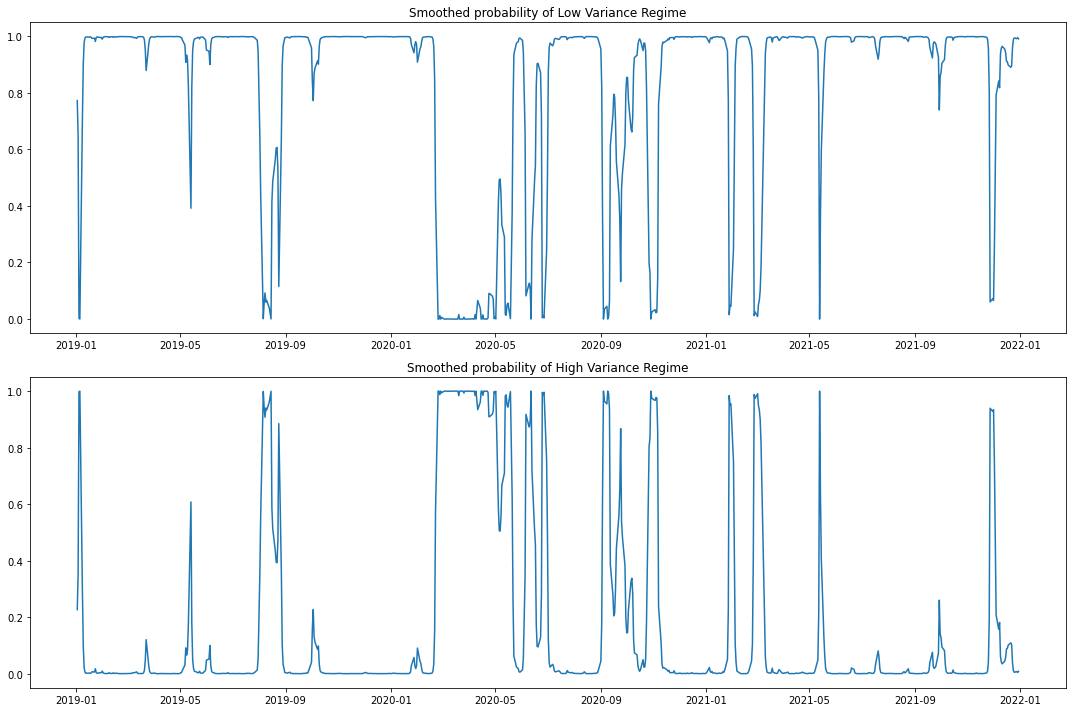

In [11]:
# Get the regime as a column, 1 as Low Variance Regime, 2 as High Variance Regime.
regime = pd.Series(model.smoothed_marginal_probabilities.values.argmax(axis=1)+1, 
                      index=returns.index, name='regime')
df_1 = close.loc[returns.index][regime == 1]
df_2 = close.loc[returns.index][regime == 2]

# Get the mean and covariance matrix of the 2 regimes, assume 0 covariance between the two.
mean = np.array([returns.loc[df_1.index].mean(), returns.loc[df_2.index].mean()])
cov = np.array([[returns.loc[df_1.index].var(), 0], [0, returns.loc[df_2.index].var()]])

# Fit a 2-dimensional multivariate normal distribution by the 2 means and covriance matrix.
dist = multivariate_normal(mean=mean.flatten(), cov=cov)
mean_1, mean_2 = mean[0], mean[1]
sigma_1, sigma_2 = cov[0,0], cov[1,1]

# Get the normal distribution of each of the distribution.
x = np.linspace(-0.05, 0.05, num=100)
y = np.linspace(-0.05, 0.05, num=100)
X, Y = np.meshgrid(x,y)
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = dist.pdf([X[i,j], Y[i,j]])

# Plot the probability of data in different regimes.
fig, axes = plt.subplots(2, figsize=(15, 10))
ax = axes[0]
ax.plot(model.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of Low Variance Regime')
ax = axes[1]
ax.plot(model.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of High Variance Regime')
fig.tight_layout()
plt.show()

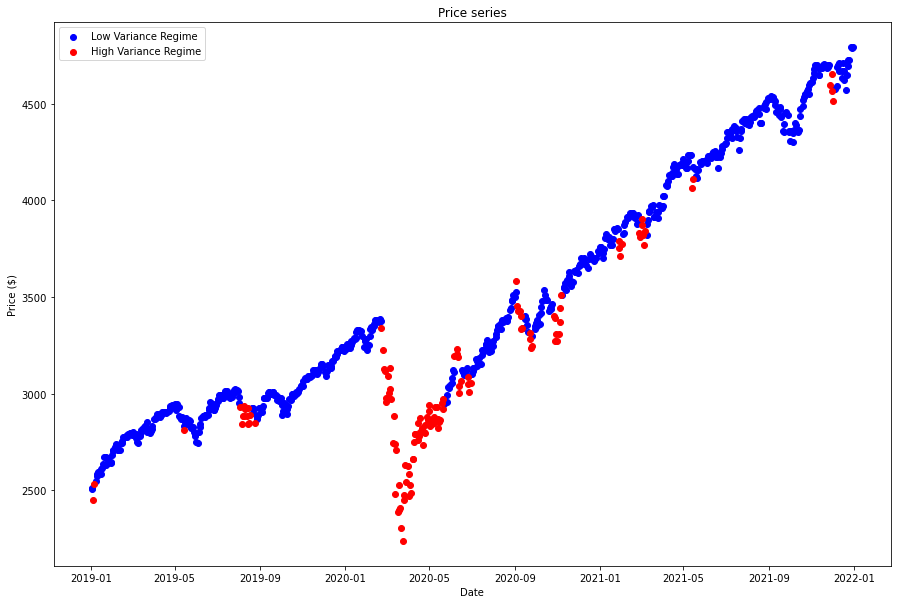

In [12]:
# Plot the series into regime-wise.
df_1.index = pd.to_datetime(df_1.index)
df_1 = df_1.sort_index()
df_2.index = pd.to_datetime(df_2.index)
df_2 = df_2.sort_index()
plt.figure(figsize=(15, 10))
plt.scatter(df_1.index, df_1, color='blue', label="Low Variance Regime")
plt.scatter(df_2.index, df_2, color='red', label="High Variance Regime")
plt.title("Price series")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.legend()
plt.show()

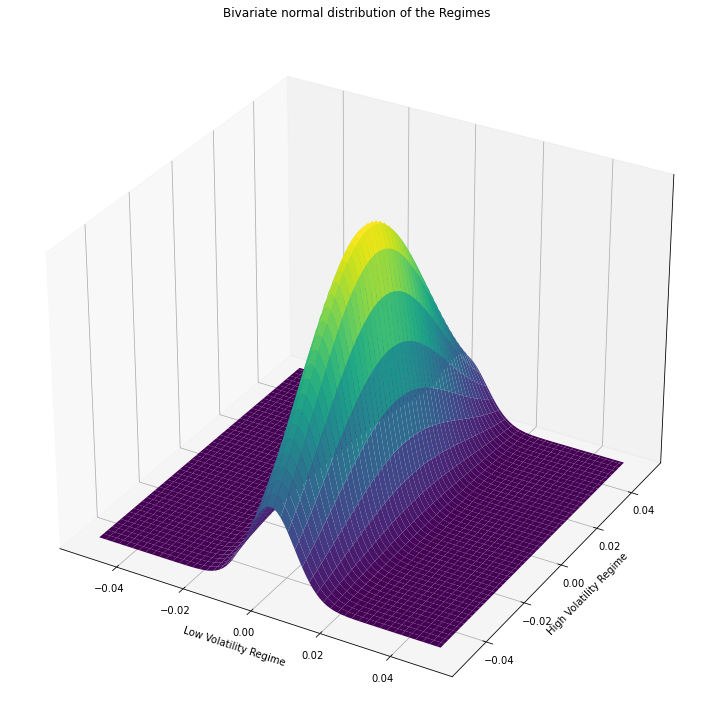

In [13]:
# Plot the distribution surface.
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(122, projection = '3d')
ax.plot_surface(X, Y, pdf, cmap = 'viridis')
ax.axes.zaxis.set_ticks([])
plt.xlabel("Low Volatility Regime")
plt.ylabel("High Volatility Regime")
plt.title('Bivariate normal distribution of the Regimes')
plt.tight_layout()
plt.show()

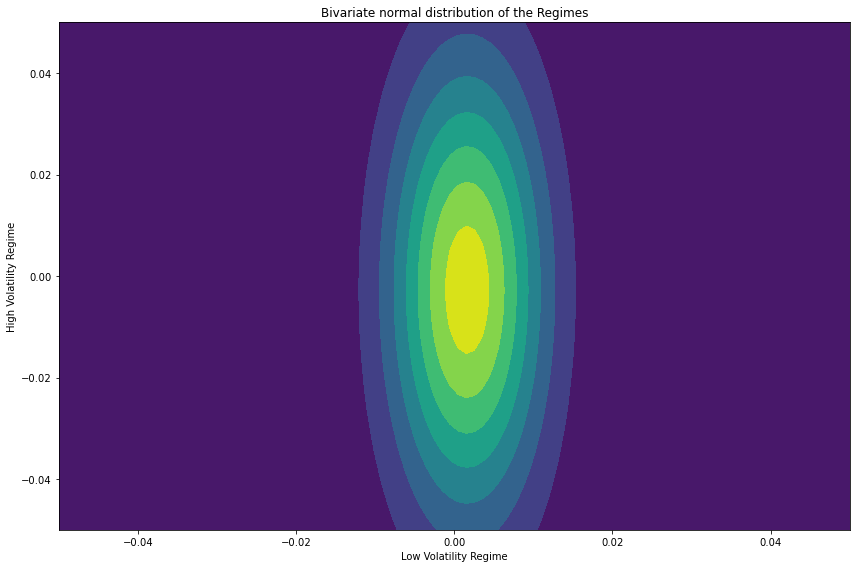

In [14]:
# plot the contour
plt.figure(figsize=(12, 8))
plt.contourf(X, Y, pdf, cmap = 'viridis')
plt.xlabel("Low Volatility Regime")
plt.ylabel("High Volatility Regime")
plt.title('Bivariate normal distribution of the Regimes')
plt.tight_layout()
plt.show()

We can clearly seen from the results, the Low Volatility Regime has much lower variance than the High Volatility Regime, proven the model works.